# SUBSTITUIÇÃO DE DADOS AUSENTES

In [125]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
dataset = fetch_openml(data_id=40536, as_frame=True)
df = dataset.frame

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 2000)  # Expand display width
pd.set_option('display.colheader_justify', 'left')  # Align headers left (optional)
pd.set_option('display.max_colwidth', None)  # Don't truncate cell content

In [127]:
cat_cols = ["age", "age_o", "race", "race_o", "importance_same_race", "importance_same_religion",
          "field", "attractive_o", "sinsere_o", "intelligence_o", "funny_o", "ambitous_o",
          "shared_interests_o", "attractive_important", "sincere_important", "intellicence_important",
          "funny_important", "ambtition_important", "shared_interests_important", "attractive", "sincere",
          "intelligence", "funny", "ambition", "attractive_partner", "sincere_partner", "intelligence_partner",
          "funny_partner", "ambition_partner", "shared_interests_partner", "sports", "tvsports", "exercise",
          "dining", "museums", "art", "hiking", "gaming", "clubbing", "reading", "tv", "theater", "movies",
          "concerts", "music", "shopping", "yoga", "expected_happy_with_sd_people",
          "expected_num_interested_in_me", "expected_num_matches", "like", "guess_prob_liked", "met"]
df[cat_cols] = df[cat_cols].astype('category')

In [128]:
df_encoded = df.apply(lambda col: pd.factorize(col)[0] if col.dtype == 'object' or col.dtype.name == 'category' else col)
spearman_corr = df_encoded.corr(method='spearman', numeric_only=False)
print(spearman_corr)

                                 has_null  wave      gender    age       age_o     d_age     d_d_age   race      race_o    samerace  importance_same_race  importance_same_religion  d_importance_same_race  d_importance_same_religion  field     pref_o_attractive  pref_o_sincere  pref_o_intelligence  pref_o_funny  pref_o_ambitious  pref_o_shared_interests  d_pref_o_attractive  d_pref_o_sincere  d_pref_o_intelligence  d_pref_o_funny  d_pref_o_ambitious  d_pref_o_shared_interests  attractive_o  sinsere_o  intelligence_o  funny_o   ambitous_o  shared_interests_o  d_attractive_o  d_sinsere_o  d_intelligence_o  d_funny_o  d_ambitous_o  d_shared_interests_o  attractive_important  sincere_important  intellicence_important  funny_important  ambtition_important  shared_interests_important  d_attractive_important  d_sincere_important  d_intellicence_important  d_funny_important  d_ambtition_important  d_shared_interests_important  attractive  sincere   intelligence  funny     ambition  d_attractive

## COLUNAS NUMERICAS

In [129]:
float_nan_cols = ["pref_o_attractive", "pref_o_sincere", "pref_o_intelligence", "pref_o_funny", "pref_o_ambitious",
          "pref_o_shared_interests", "interests_correlate"]

In [130]:
def evaluate_correlation_change(original_corr, imputed_df):
    """Calculate the change in correlation matrices."""
    new_corr = imputed_df.select_dtypes(include=[np.number]).corr()

    # Ensure we only calculate over valid overlapping indices
    common_cols = original_corr.index.intersection(new_corr.index)
    return np.sum(np.abs(original_corr.loc[common_cols, common_cols] - new_corr.loc[common_cols, common_cols]).values)

In [131]:
def best_imputation(df, methods=['mean', 'median', 'most_frequent', 'knn']):
    """
    Finds the best imputation method per column by selecting the one
    that causes the least correlation change.
    """
    original_corr = df.corr()
    best_methods = {}
    best_imputed_df = df.copy()

    for col in df.columns:
        if df[col].isna().sum() > 0:  # Only process columns with missing values
            best_score = float('inf')
            best_imputed_col = None
            best_method = None

            for method in methods:
                df_temp = best_imputed_df.copy()

                if method == 'knn':
                    imputer = KNNImputer(n_neighbors=5)
                else:
                    imputer = SimpleImputer(strategy=method)

                df_temp[[col]] = imputer.fit_transform(df_temp[[col]])

                score = evaluate_correlation_change(original_corr, df_temp)

                if score < best_score:
                    best_score = score
                    best_imputed_col = df_temp[col]
                    best_method = method

            best_methods[col] = best_method
            best_imputed_df[col] = best_imputed_col

    return best_imputed_df, best_methods

In [132]:
df_selected = df[float_nan_cols].copy()

original_corr = df.select_dtypes(include=[np.number]).corr()

num_imputed_df, chosen_methods = best_imputation(df_selected)

# Print results
print("Imputed DataFrame:\n", num_imputed_df.head())
print("\nBest Imputation Methods per Column:\n", chosen_methods)

new_corr = num_imputed_df.select_dtypes(include=[np.number]).corr()

correlation_diff = np.abs(original_corr - new_corr)

Imputed DataFrame:
    pref_o_attractive  pref_o_sincere  pref_o_intelligence  pref_o_funny  pref_o_ambitious  pref_o_shared_interests  interests_correlate
0  35.0               20.0            20.0                 20.0           0.0               5.0                     0.14               
1  60.0                0.0             0.0                 40.0           0.0               0.0                     0.54               
2  19.0               18.0            19.0                 18.0          14.0              12.0                     0.16               
3  30.0                5.0            15.0                 40.0           5.0               5.0                     0.61               
4  30.0               10.0            20.0                 10.0          10.0              20.0                     0.21               

Best Imputation Methods per Column:
 {'pref_o_attractive': 'mean', 'pref_o_sincere': 'mean', 'pref_o_intelligence': 'median', 'pref_o_funny': 'mean', 'pref_o_ambit

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


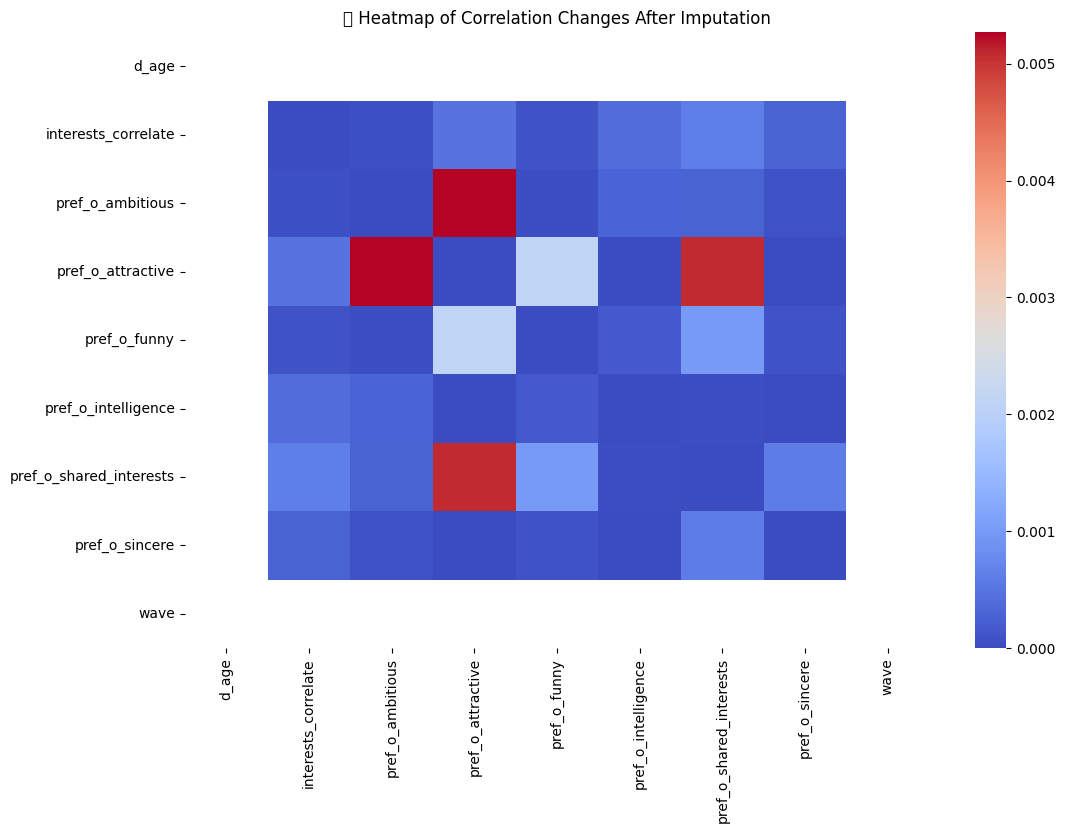

In [133]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_diff, cmap="coolwarm", annot=False)
plt.title("🔥 Heatmap of Correlation Changes After Imputation")
plt.show()

## COLUNAS CATEGORICAS

In [134]:
categ_nan_cols = ["age", "age_o", "race", "race_o", "importance_same_race", "importance_same_religion",
          "field", "attractive_o", "sinsere_o", "intelligence_o", "funny_o", "ambitous_o",
          "shared_interests_o", "attractive_important", "sincere_important", "intellicence_important",
          "funny_important", "ambtition_important", "shared_interests_important", "attractive", "sincere",
          "intelligence", "funny", "ambition", "attractive_partner", "sincere_partner", "intelligence_partner",
          "funny_partner", "ambition_partner", "shared_interests_partner", "sports", "tvsports", "exercise",
          "dining", "museums", "art", "hiking", "gaming", "clubbing", "reading", "tv", "theater", "movies",
          "concerts", "music", "shopping", "yoga", "expected_happy_with_sd_people",
          "expected_num_interested_in_me", "expected_num_matches", "like", "guess_prob_liked", "met"]

In [135]:
def impute_categorical(df, categorical_columns):
    df_imputed = df.copy()

    for col in categorical_columns:
        if df_imputed[col].isna().sum() > 0:  # Process only columns with missing values
            # print(f"Imputing missing values for: {col}")

            label_encoder = LabelEncoder()

            # Encode non-null values
            df_imputed[col + "_encoded"] = np.nan
            non_null_mask = df_imputed[col].notna()
            df_imputed.loc[non_null_mask, col + "_encoded"] = label_encoder.fit_transform(df_imputed.loc[non_null_mask, col])

            # Identify rows with missing values
            missing_mask = df_imputed[col].isna()

            # Define numerical features for prediction
            feature_cols = [c for c in df.columns if df[c].dtype in [np.float64, np.int64] and c not in categorical_columns]

            # Ensure numerical features do not have missing values
            X = df_imputed.loc[~missing_mask, feature_cols].copy()
            y = df_imputed.loc[~missing_mask, col + "_encoded"].copy()

            if X.isna().sum().sum() > 0:
                X = X.fillna(X.mean())  # Fill missing numerical values with mean

            # Train a classification model
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X, y)

            # Predict missing values
            X_missing = df_imputed.loc[missing_mask, feature_cols].copy()
            if X_missing.isna().sum().sum() > 0:
                X_missing = X_missing.fillna(X.mean())  # Fill missing numerical values

            predictions = model.predict(X_missing)

            # Assign predictions back, ensuring correct index alignment
            df_imputed.loc[missing_mask, col + "_encoded"] = predictions

            # Convert numeric labels back to original categories
            df_imputed[col] = label_encoder.inverse_transform(df_imputed[col + "_encoded"].astype(int))

            # Drop the encoded column (optional)
            df_imputed.drop(columns=[col + "_encoded"], inplace=True)

    return df_imputed

In [136]:
original_corr = df.select_dtypes(include=[np.number]).corr()

cat_imputed_df = impute_categorical(df.copy(), categ_nan_cols)

new_corr = cat_imputed_df.select_dtypes(include=[np.number]).corr()

correlation_diff = np.abs(original_corr - new_corr)

In [137]:
for col in categ_nan_cols:
    print(f"\n🔍 {col} BEFORE Imputation:")
    print(df[col].value_counts(normalize=True).head(5))  # Show top 5 most frequent values

    print(f"\n🔍 {col} AFTER Imputation:")
    print(cat_imputed_df[col].value_counts(normalize=True).head(5))  # Check if distribution changed



🔍 age BEFORE Imputation:
age
27.0    0.127852
23.0    0.107932
26.0    0.104914
24.0    0.104189
25.0    0.101050
Name: proportion, dtype: float64

🔍 age AFTER Imputation:
age
27.0    0.127238
23.0    0.107066
26.0    0.104321
24.0    0.103485
25.0    0.100501
Name: proportion, dtype: float64

🔍 age_o BEFORE Imputation:
age_o
27.0    0.127991
23.0    0.108049
26.0    0.105028
24.0    0.104303
25.0    0.101160
Name: proportion, dtype: float64

🔍 age_o AFTER Imputation:
age_o
27.0    0.126402
23.0    0.109692
26.0    0.107902
24.0    0.103008
25.0    0.099905
Name: proportion, dtype: float64

🔍 race BEFORE Imputation:
race
European/Caucasian-American              0.568491
Asian/Pacific Islander/Asian-American    0.238364
Latino/Hispanic American                 0.079856
Other                                    0.062778
Black/African American                   0.050511
Name: proportion, dtype: float64

🔍 race AFTER Imputation:
race
European/Caucasian-American              0.571497
Asian/

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


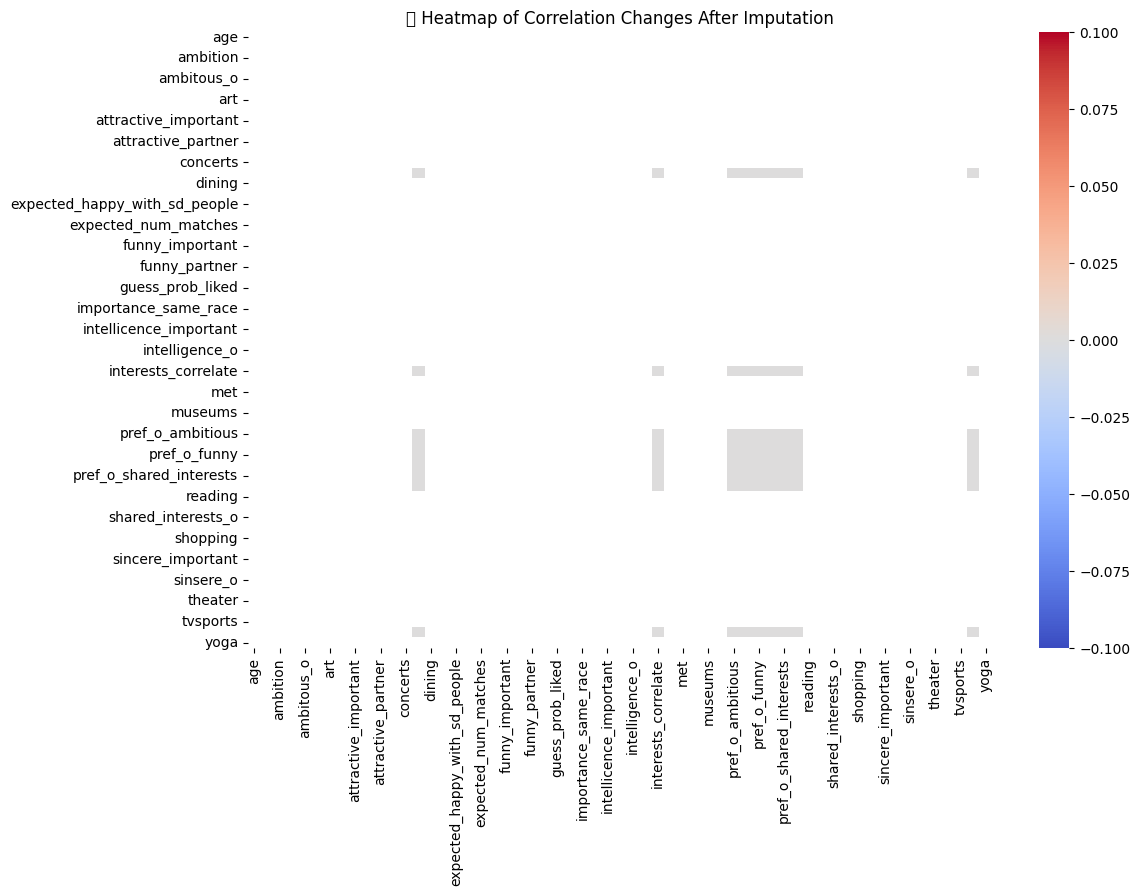

In [138]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_diff, cmap="coolwarm", annot=False)
plt.title("🔥 Heatmap of Correlation Changes After Imputation")
plt.show()


In [140]:
df = cat_imputed_df
df[float_nan_cols] = num_imputed_df

In [141]:
print(df.isnull().sum())

has_null                           0
wave                               0
gender                             0
age                                0
age_o                              0
d_age                              0
d_d_age                            0
race                               0
race_o                             0
samerace                           0
importance_same_race               0
importance_same_religion           0
d_importance_same_race             0
d_importance_same_religion         0
field                              0
pref_o_attractive                  0
pref_o_sincere                     0
pref_o_intelligence                0
pref_o_funny                       0
pref_o_ambitious                   0
pref_o_shared_interests            0
d_pref_o_attractive                0
d_pref_o_sincere                   0
d_pref_o_intelligence              0
d_pref_o_funny                     0
d_pref_o_ambitious                 0
d_pref_o_shared_interests          0
a

In [145]:
cat_cols = ["age", "age_o", "importance_same_race", "importance_same_religion",
          "attractive_o", "sinsere_o", "intelligence_o", "funny_o", "ambitous_o",
          "shared_interests_o", "attractive_important", "sincere_important", "intellicence_important",
          "funny_important", "ambtition_important", "shared_interests_important", "attractive", "sincere",
          "intelligence", "funny", "ambition", "attractive_partner", "sincere_partner", "intelligence_partner",
          "funny_partner", "ambition_partner", "shared_interests_partner", "sports", "tvsports", "exercise",
          "dining", "museums", "art", "hiking", "gaming", "clubbing", "reading", "tv", "theater", "movies",
          "concerts", "music", "shopping", "yoga", "expected_happy_with_sd_people",
          "expected_num_interested_in_me", "expected_num_matches", "like", "guess_prob_liked", "met"]
df[cat_cols] = df[cat_cols].astype('float64')

## VISUALIZAÇÃO SPEARMAN FINAL

In [146]:
df_encoded = df.apply(lambda col: pd.factorize(col)[0] if col.dtype == 'object' or col.dtype.name == 'category' else col)
spearman_corr = df_encoded.corr(method='spearman', numeric_only=False)
print(spearman_corr)

                                 has_null  wave      gender    age       age_o     d_age     d_d_age   race      race_o    samerace  importance_same_race  importance_same_religion  d_importance_same_race  d_importance_same_religion  field     pref_o_attractive  pref_o_sincere  pref_o_intelligence  pref_o_funny  pref_o_ambitious  pref_o_shared_interests  d_pref_o_attractive  d_pref_o_sincere  d_pref_o_intelligence  d_pref_o_funny  d_pref_o_ambitious  d_pref_o_shared_interests  attractive_o  sinsere_o  intelligence_o  funny_o   ambitous_o  shared_interests_o  d_attractive_o  d_sinsere_o  d_intelligence_o  d_funny_o  d_ambitous_o  d_shared_interests_o  attractive_important  sincere_important  intellicence_important  funny_important  ambtition_important  shared_interests_important  d_attractive_important  d_sincere_important  d_intellicence_important  d_funny_important  d_ambtition_important  d_shared_interests_important  attractive  sincere   intelligence  funny     ambition  d_attractive